In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt
from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

measurment = Base.classes.measurement
station = Base.classes.station

In [9]:
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
first_row = session.query(measurment).first()
first_row.__dict__



{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcd11cb5850>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [12]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcd11cb5e50>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [13]:
max_date = session.query(func.max(measurment.date)).first()
twelve_months_prior = dt.datetime.strptime(max_date[0],"%Y-%m-%d") - dt.timedelta(days=365)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

query_results = session.query(func.sum(measurment.prcp), measurment.date).\
                    group_by(measurment.date).\
                    filter(measurment.date >= twelve_months_prior).\
                    order_by(measurment.date)

last_12_months_df = pd.DataFrame(query_results, columns=["Precip", "Date"])
last_12_months_df

,Precip,Date
0,9.33,2016-08-24
1,0.54,2016-08-25
2,0.10,2016-08-26
3,0.32,2016-08-27
4,3.10,2016-08-28
...,...,...
360,0.09,2017-08-19
361,0.01,2017-08-20
362,0.58,2017-08-21
363,0.50,2017-08-22


Text(0, 0.5, 'Precipitation (in)')

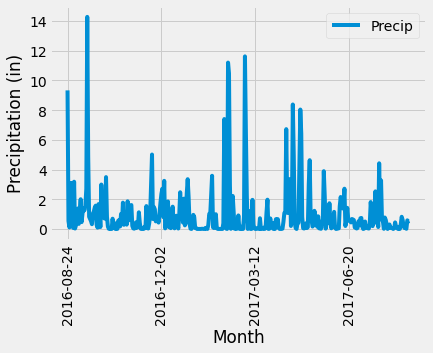

In [15]:
last_12_months_df.plot(x='Date', y='Precip', rot=90)
plt.xlabel("Month")
plt.ylabel("Precipitation (in)")

In [16]:
# Calculate the date 1 year ago from the last data point in the database
max_date

('2017-08-23')

In [17]:
query_results_again = session.query(measurment.prcp, measurment.date).\
                        filter(measurment.date >= twelve_months_prior).\
                        order_by(measurment.date)


In [18]:
query_results_new_df_again = pd.DataFrame(query_results_again, columns=["Precipitation", "Date"])

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_results_new_df_again.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.station)
for row in station_count: 
    print(row)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_results = session.query(measurment.station,func.count(measurment.station)).\
                    group_by(measurment.station).\
                    order_by(func.count(measurment.station).desc())

# List the stations and the counts in descending order.
for row in station_results: 
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = session.query(measurment.station,func.count(measurment.station)).\
                    group_by(measurment.station).\
                    order_by(func.count(measurment.station).desc()).first()
    
max_temp = session.query(measurment.station, func.max(measurment.tobs)).\
               filter(measurment.station == active_station[0])
min_temp = session.query(measurment.station, func.min(measurment.tobs)).\
               filter(measurment.station == active_station[0])              

avg_temp = session.query(measurment.station, func.avg(measurment.tobs)).\
               filter(measurment.station == active_station[0])  



for row in max_temp:
    print(row)
for row in min_temp: 
    print(row)
for row in avg_temp: 
    print(row)

('USC00519281', 85.0)
('USC00519281', 54.0)
('USC00519281', 71.66378066378067)


In [23]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_active_station = session.query(func.sum(measurment.tobs), measurment.date).\
                    group_by(measurment.date).\
                    filter(measurment.date >= twelve_months_prior, measurment.station == active_station[0]).\
                    order_by(measurment.date)

active_station_df = pd.DataFrame(query_active_station, columns=["Temp", "Date"])
active_station_df



,Temp,Date
0,77.0,2016-08-24
1,80.0,2016-08-25
2,80.0,2016-08-26
3,75.0,2016-08-27
4,73.0,2016-08-28
...,...,...
346,77.0,2017-08-14
347,77.0,2017-08-15
348,76.0,2017-08-16
349,76.0,2017-08-17


Text(0.5, 1.0, 'Precipitation frequency for Station USC00519281')

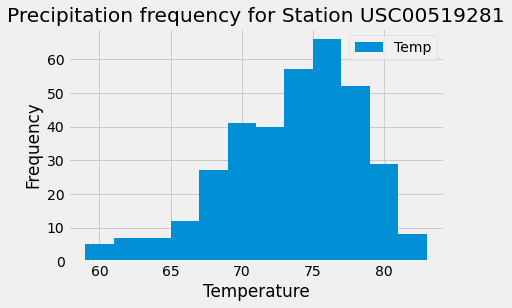

In [24]:
active_station_df.plot.hist(bins=12, alpha = 1)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Precipitation frequency for Station USC00519281")



In [25]:
# - - - - - - MERGING TABLES FOR FLASK ASSIGNMENT - - - - - ##

In [26]:
measurment_df = pd.read_csv("Resources/hawaii_measurements.csv")
station_df = pd.read_csv("Resources/hawaii_stations.csv")
merged = measurment_df.merge(station_df, how = 'outer', on = 'station')

merged.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00519397,2010-01-01,0.08,65,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


## Bonus Challenge Assignment